# Quantize a vector


## Quantize a vector using EasyQuant

Since the vector has a very short length, no outlier detection was done.

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import torch

# Add the parent directory to the path
sys.path.append(os.path.abspath(".."))
print(sys.path)

from core.models.easy_quant import EasyQuantConfig, EasyQuant
from core.utils.quantization_helpers import compute_quantization_error

['/opt/anaconda3/lib/python311.zip', '/opt/anaconda3/lib/python3.11', '/opt/anaconda3/lib/python3.11/lib-dynload', '', '/Users/deyucao/Library/Caches/pypoetry/virtualenvs/quantization-ubRKDRCl-py3.11/lib/python3.11/site-packages', '/Users/deyucao/Quantization']


In [3]:
original_vector = [3.2, -1.4, 2.5, -0.9, 1.8, -3.7, 0.0, 4.0, 2.2, -1.3]
original_tensor = torch.tensor(original_vector)

num_bits = 3

In [4]:
# naive quantization
max_val = torch.max(torch.abs(original_tensor))
step_size = max_val / ((2 ** (num_bits - 1)) - 1)
print(f"Step size: {step_size}")
quantized_tensor_naive = torch.round(original_tensor / step_size) * step_size

# compute quantization error
quantization_error_naive = compute_quantization_error(original_tensor, quantized_tensor_naive)

print(f"Original tensor: {original_tensor}")
print(f"Naive quantized tensor: {quantized_tensor_naive}")
print(f"Quantization error (naive): {quantization_error_naive}")

Step size: 1.3333333730697632
Original tensor: tensor([ 3.2000, -1.4000,  2.5000, -0.9000,  1.8000, -3.7000,  0.0000,  4.0000,
         2.2000, -1.3000])
Naive quantized tensor: tensor([ 2.6667, -1.3333,  2.6667, -1.3333,  1.3333, -4.0000,  0.0000,  4.0000,
         2.6667, -1.3333])
Quantization error (naive): 1.0311110019683838


In [10]:
# quantize the vector using EasyQuant
config = EasyQuantConfig(learning_rate=1e-3, num_epochs=200)

easy_quant_wrapper = EasyQuant(num_bits=num_bits, config=config, verbose=True)

q_range, quantized_vector, q_range_history, reconstruction_error_history = easy_quant_wrapper.quantize_and_reconstruct(original_tensor)

Optimizing quantization range using EasyQuant algorithm
Learning rate: 0.001
Number of epochs: 200
Initial quantization range: 1.3333333730697632
Epoch 1: Quantization range = 1.3323333263397217, Reconstruction error = 1.0311110019683838
Epoch 2: Quantization range = 1.3313343524932861, Reconstruction error = 1.0290783643722534
Epoch 3: Quantization range = 1.3303370475769043, Reconstruction error = 1.027115821838379
Epoch 4: Quantization range = 1.329342246055603, Reconstruction error = 1.025223970413208
Epoch 5: Quantization range = 1.3283507823944092, Reconstruction error = 1.0234044790267944
Epoch 6: Quantization range = 1.32736337184906, Reconstruction error = 1.0216578245162964
Epoch 7: Quantization range = 1.326380968093872, Reconstruction error = 1.0199849605560303
Epoch 8: Quantization range = 1.325404405593872, Reconstruction error = 1.0183862447738647
Epoch 9: Quantization range = 1.3244346380233765, Reconstruction error = 1.016862154006958
Epoch 10: Quantization range = 1.3

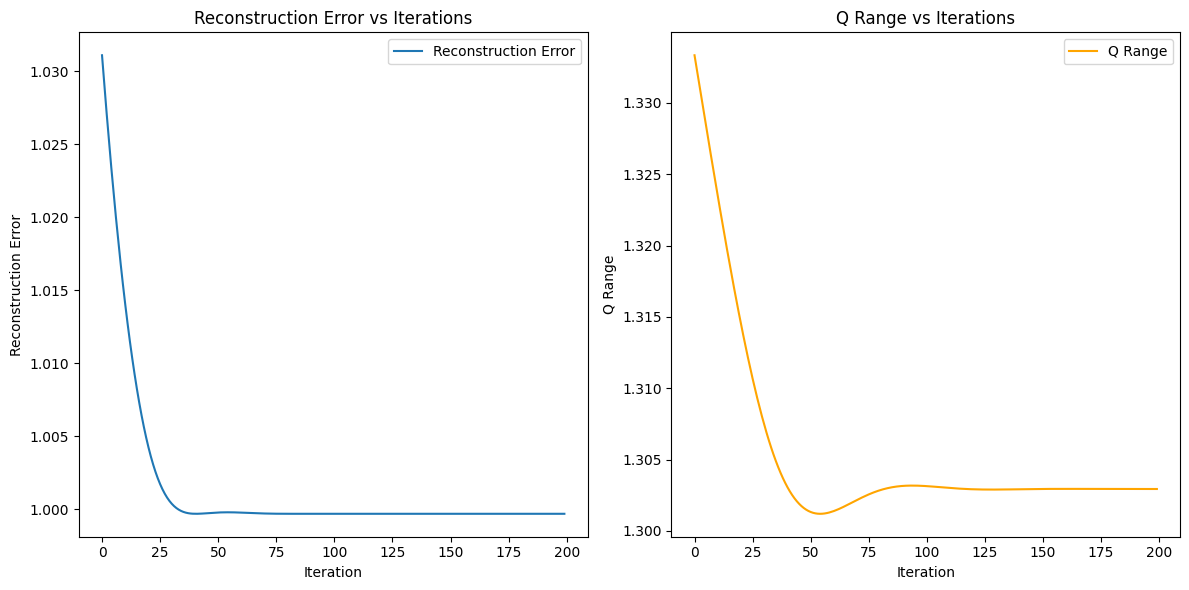

In [11]:
# Plot reconstruction error
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_history, label="Reconstruction Error")
plt.xlabel("Iteration")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs Iterations")
plt.legend()

# Plot q_range
plt.subplot(1, 2, 2)
plt.plot(q_range_history, label="Q Range", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Q Range")
plt.title("Q Range vs Iterations")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print(f"Original Vector: {original_vector}")
print(f"Quantized Vector: {quantized_vector}")

Original Vector: [3.2, -1.4, 2.5, -0.9, 1.8, -3.7, 0.0, 4.0, 2.2, -1.3]
Quantized Vector: tensor([ 2.6059, -1.3029,  2.6059, -1.3029,  1.3029, -3.9088,  0.0000,  3.9088,
         2.6059, -1.3029])


In [13]:
print(f"Quantization Error: {compute_quantization_error(original_tensor, quantized_vector)}")

Quantization Error: 0.9997058510780334


# Quantize a vector using SqueezeLLM

Since the values in the vector has no sensitivity information, uniform-weight k-means was used.

In [7]:
from core.models.squeeze_llm import SqueezeQuant, SqueezeQuantConfig

In [8]:
squeeze_quant_config = SqueezeQuantConfig(k_means_max_iter=100, use_sensitivity=False)

squeeze_quant_wrapper = SqueezeQuant(num_bits=num_bits, config=squeeze_quant_config, verbose=True)

reconstructed_data, _ = squeeze_quant_wrapper.quantize_and_reconstruct(original_tensor)

In [9]:
print(f"Original Vector: {original_tensor}")
print(f"Reconstructed Vector: {reconstructed_data}")

print(f"Quantization Error: {compute_quantization_error(original_tensor, reconstructed_data)}")

Original Vector: tensor([ 3.2000, -1.4000,  2.5000, -0.9000,  1.8000, -3.7000,  0.0000,  4.0000,
         2.2000, -1.3000])
Reconstructed Vector: tensor([ 3.2000, -1.3500,  2.3500, -0.9000,  1.8000, -3.7000,  0.0000,  4.0000,
         2.3500, -1.3500])
Quantization Error: 0.049999989569187164


**Observation**

From the comparison of L2 quantization error, you can see that the non-uniform quantization method can achieve better quantization in terms of accuracy. This is a natural result because non-uniform quantization has less constraints and can fit better to the original data. (In this case, it's clustering 10 values into 8 unique values, so it's no wonder the reconstruction error is extremely low.